In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
# Load datasets
customers = pd.read_csv(r"D:\Zeotap\Dataset\Customers.csv")
transactions = pd.read_csv(r"D:\Zeotap\Dataset\Transactions.csv")

In [3]:
# Convert dates
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

In [4]:
# Feature Engineering
# Customer features
customer_features = customers.copy()
customer_features['DaysSinceSignup'] = (datetime.now() - customer_features['SignupDate']).dt.days

# Transaction features
transaction_features = transactions.groupby('CustomerID', as_index=False).agg({
    'TotalValue': ['sum', 'mean', 'count'],
    'Quantity': 'sum'
})
transaction_features.columns = ['CustomerID', 'TotalSpend', 'AverageOrderValue', 'NumTransactions', 'TotalQuantity']

# Merge customer and transaction features
all_features = pd.merge(customer_features[['CustomerID', 'Region', 'DaysSinceSignup']], transaction_features, on='CustomerID')
all_features = pd.get_dummies(all_features, columns=['Region'])  # One-hot encode Region

# Prepare for clustering
features = all_features.drop('CustomerID', axis=1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [5]:
# Function to evaluate clustering with DB Index
def evaluate_cluster(X, model):
    labels = model.fit_predict(X)
    db_index = davies_bouldin_score(X, labels)
    return db_index


In [6]:

# Testing different numbers of clusters with KMeans
db_scores = []
n_clusters = range(2, 11)
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42)
    db_scores.append(evaluate_cluster(scaled_features, kmeans))

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there

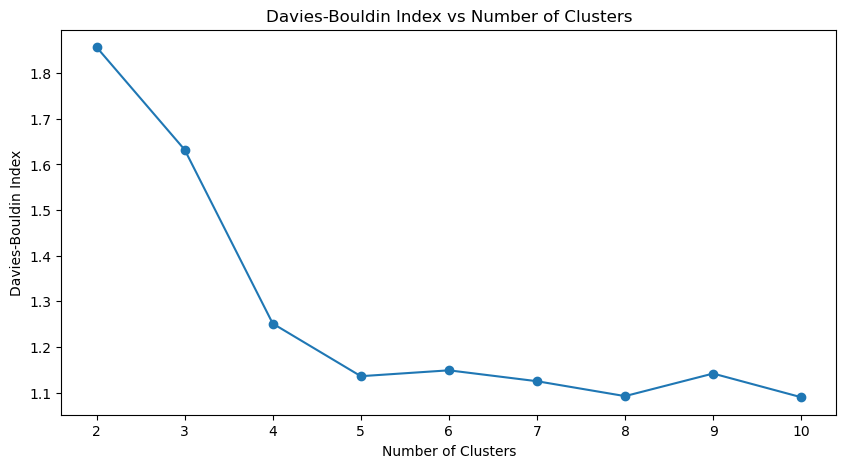

In [7]:
# Plot DB Index to help decide optimal clusters
plt.figure(figsize=(10, 5))
plt.plot(n_clusters, db_scores, marker='o')
plt.title('Davies-Bouldin Index vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.show()

In [8]:
# Choose the number of clusters (for example, where DB Index starts to increase or stabilize)
optimal_clusters = 4  # Based on the plot, let's say 4 clusters seem optimal
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
labels = kmeans.fit_predict(scaled_features)

# Adding cluster labels back to our dataset
all_features['Cluster'] = labels

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


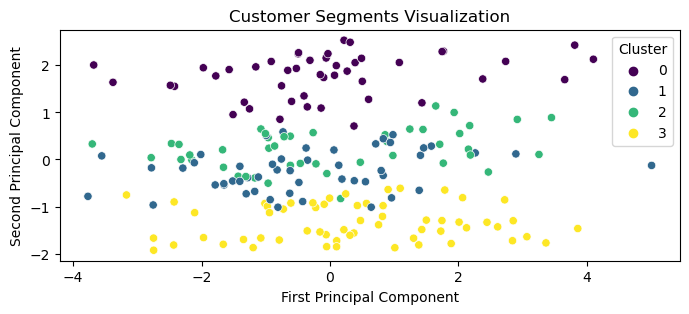

In [17]:
# Visualizing clusters with PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = labels

plt.figure(figsize=(8, 3))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis')
plt.title('Customer Segments Visualization')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

In [10]:
# Analyze clusters
for i in range(optimal_clusters):
    cluster_data = all_features[all_features['Cluster'] == i]
    print(f"Cluster {i} Summary:")
    print(cluster_data.describe())
    print("\n")

Cluster 0 Summary:
       DaysSinceSignup   TotalSpend  AverageOrderValue  NumTransactions  \
count        46.000000    46.000000          46.000000        46.000000   
mean        450.217391  3311.160870         639.956633         5.304348   
std         328.751775  1701.181711         219.648174         2.511038   
min          64.000000   132.640000         132.640000         1.000000   
25%         188.500000  2349.112500         501.614682         4.000000   
50%         362.000000  3034.210000         621.627500         5.000000   
75%         638.750000  3989.807500         773.674000         7.000000   
max        1088.000000  7663.700000        1141.440000        11.000000   

       TotalQuantity  Cluster  
count      46.000000     46.0  
mean       12.891304      0.0  
std         6.307767      0.0  
min         1.000000      0.0  
25%        10.000000      0.0  
50%        12.000000      0.0  
75%        14.000000      0.0  
max        32.000000      0.0  


Cluster 1 Summa

In [11]:
# Report on clustering
print(f"Number of Clusters: {optimal_clusters}")
print(f"DB Index Value: {evaluate_cluster(scaled_features, kmeans)}")

Number of Clusters: 4


C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


DB Index Value: 1.2513454911241075


In [12]:
# Save results to CSV on D drive
output_file_path = 'D:/CustomerClusters.csv'
all_features.to_csv(output_file_path, index=False)

In [13]:
pd.read_csv(r'D:/CustomerClusters.csv')

,CustomerID,DaysSinceSignup,TotalSpend,AverageOrderValue,NumTransactions,TotalQuantity,Region_Asia,Region_Europe,Region_North America,Region_South America,Cluster
0,C0001,930,3354.52,670.904000,5,12,False,False,False,True,3
1,C0002,1077,1862.74,465.685000,4,10,True,False,False,False,2
2,C0003,324,2725.38,681.345000,4,14,False,False,False,True,3
3,C0004,839,5354.88,669.360000,8,23,False,False,False,True,3
4,C0005,894,2034.24,678.080000,3,7,True,False,False,False,2
...,...,...,...,...,...,...,...,...,...,...,...
194,C0196,963,4982.88,1245.720000,4,12,False,True,False,False,1
195,C0197,676,1928.65,642.883333,3,9,False,True,False,False,1
196,C0198,1063,931.83,465.915000,2,3,False,True,False,False,1
197,C0199,784,1979.28,494.820000,4,9,False,True,False,False,1
